## AdventureWorks Försäljningsanalys

I den här analysen kommer vi att göra en undersökning av Adventureworks 2025-databasen för att besvara följande affärsfrågor.

- Hur många produkter finns i varje kategori?
- Vilka produktkategorier genererar mest intäkter?
- Hur har försäljningen utvecklats över tid?
- Hur ser total försäljning och antal ordrar ut per år?
- Vilka 10 produkter genererar mest försäljning?
- Hur skiljer sig försäljningen mellan olika regioner, och hur många unika kunder har varje region?
- Vilka regioner har högst/lägst genomsnittligt ordervärde, och skiljer det sig mellan individuella kunder och företagskunder?

  ##### Och

ALTERNATIV A: Regional försäljningsoptimering vilken har följande analysfrågor:

-	Vilken region presterar bäst/sämst?
-	Vilka produktkategorier säljer bäst var?
-	Finns säsongsmönster per region?
-	Rekommendationer för förbättring?

#### Vi använder SQL för att hämta data och Python för att analysera data.

In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, text
from urllib.parse import quote_plus

# Databaskonfiguration
server = 'localhost'
database = 'AdventureWorks2025'
driver = quote_plus("ODBC Driver 18 for SQL server")


connection_string = (
    f"mssql+pyodbc://@{server}/{database}"
    f"?driver={driver}&trusted_connection=yes&Encrypt=yes&TrustServerCertificate=yes"
)

engine = create_engine(connection_string)



### 1: Antal produkter per kategori

**Affärsfråga:**
- Hur många produkter finns i varje kategori?

**Visualisering**
- Vertikalt stapeldiagram (bar)

c:\adventureworks-analysis\.venv\Lib\site-packages\pandas\io\sql.py:1648: SAWarning: Unrecognized server version info '17.0.1000.7'.  Some SQL Server features may not function properly.
  con = self.exit_stack.enter_context(con.connect())


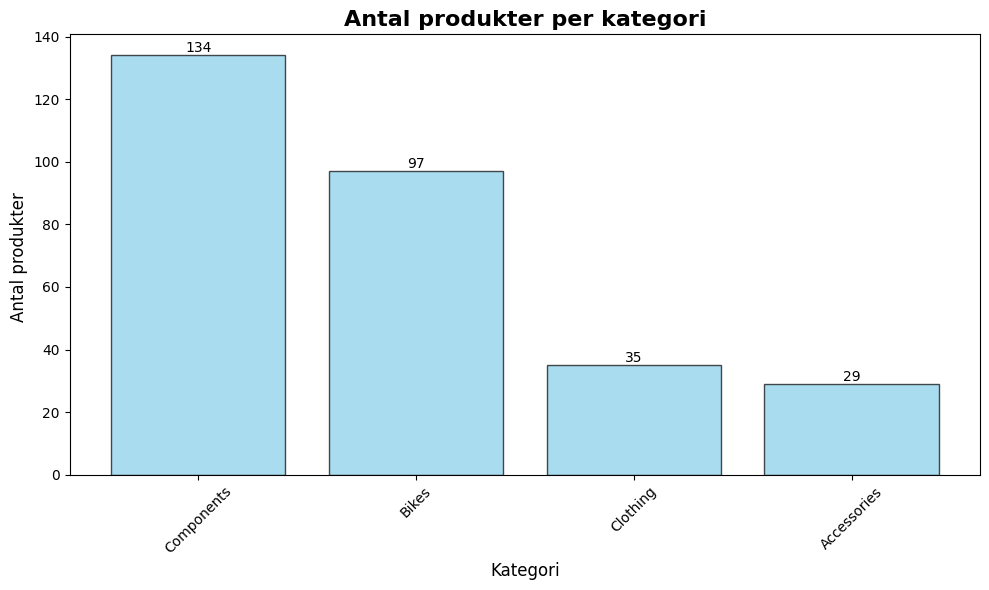

Flest produkter: Components (134)
Minst produkter: Accessories (29)


In [3]:
query = """
SELECT 
    pc.Name AS CategoryName,
    COUNT(DISTINCT p.ProductID) AS NumberOfProducts
FROM Production.ProductCategory pc
JOIN Production.ProductSubcategory psc
    ON pc.ProductCategoryID = psc.ProductCategoryID
JOIN Production.Product p
    ON psc.ProductSubcategoryID = p.ProductSubcategoryID
GROUP BY pc.Name
ORDER BY NumberOfProducts DESC;
"""

df = pd.read_sql(query, engine)
df
plt.figure(figsize=(10,6))
bars= plt.bar(df['CategoryName'], df['NumberOfProducts'], color='skyblue', edgecolor='black', alpha= 0.7)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{int(height)}', 
             ha='center', va='bottom', fontsize=10)

plt.title("Antal produkter per kategori", fontsize=16, fontweight= "bold")
plt.xlabel("Kategori", fontsize=12)
plt.ylabel("Antal produkter ", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


max_row = df.loc[df['NumberOfProducts'].idxmax()]
min_row = df.loc[df['NumberOfProducts'].idxmin()]
print(f'Flest produkter: {max_row['CategoryName']} ({int(max_row['NumberOfProducts'])})')
print(f'Minst produkter: {min_row['CategoryName']} ({int(min_row['NumberOfProducts'])})')



### 2: Försäljning per produktkategori

**Affärsfråga:**  
- Vilka produktkategorier genererar mest intäkter?

**Visualisering:**  
- Horisontellt stapeldiagram (barh)  
-  Sortera staplar från högst till lägst (högsta överst)

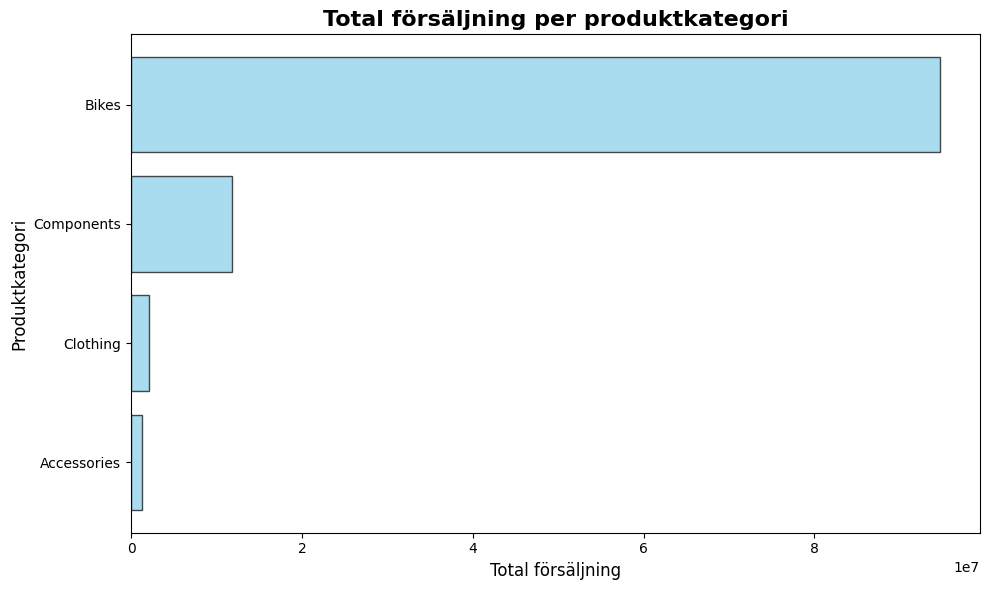

In [4]:
query = """
SELECT
    pc.Name AS CategoryName,
    SUM(sod.LineTotal) AS TotalSales
FROM Production.ProductCategory pc
JOIN Production.ProductSubcategory psc
    ON pc.ProductCategoryID = psc.ProductCategoryID
JOIN Production.Product p
    ON psc.ProductSubcategoryID = p.ProductSubcategoryID
JOIN Sales.SalesOrderDetail sod
    ON p.ProductID = sod.ProductID
GROUP BY pc.Name
ORDER BY TotalSales DESC;
"""

df_sales = pd.read_sql(query, engine)
df_sales

plt.figure(figsize=(10,6))
plt.barh(df_sales['CategoryName'], df_sales['TotalSales'], color='skyblue', edgecolor='black', alpha= 0.7)
plt.title("Total försäljning per produktkategori", fontsize=16, fontweight= "bold")
plt.xlabel("Total försäljning", fontsize=12)
plt.ylabel("Produktkategori", fontsize=12)
plt.gca().invert_yaxis()  # högsta överst
plt.tight_layout()
plt.show()


**Insikter**

- Produktkategorin **Bikes** genererar mest intäkter
  med en total försäljning på **94651172.70**.
- Produktkategorin **Accessories** genererar minst intäkter
  med en total försäljning på **1272072.88**.

Detta visar vilka produktområden som är lönsamma
och kan användas för strategiska beslut.


### 3: Försäljningstrend över tid

**Affärsfråga:** 

- Hur har försäljningen utvecklats över tid?

**Visualisering:**
  
- Tydlig tidslinje på X-axeln 

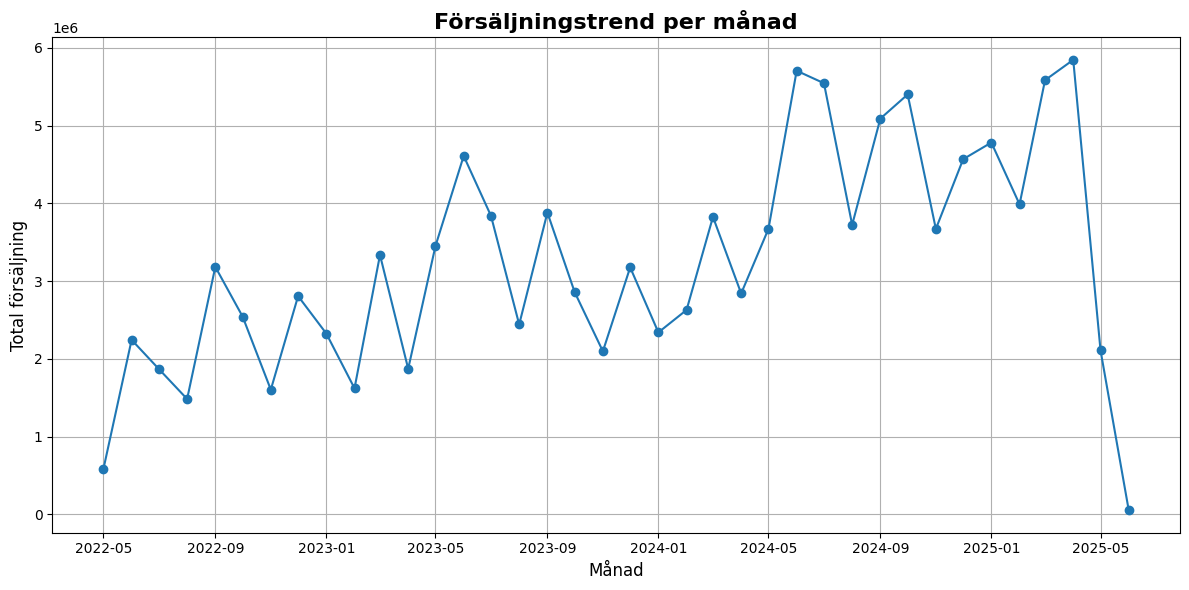

Högsta månad: 2025-04-01 (5847164.69)
Lägsta månad: 2025-06-01 (52478.19)


In [5]:
query = """
SELECT
    FORMAT(OrderDate, 'yyyy-MM') AS OrderMonth,
    SUM(TotalDue) AS MonthlySales
FROM Sales.SalesOrderHeader
GROUP BY FORMAT(OrderDate, 'yyyy-MM')
HAVING COUNT(*) > 0
ORDER BY OrderMonth;
"""

df_trend = pd.read_sql(query, engine)
df_trend

df_trend['OrderMonth'] = pd.to_datetime(df_trend['OrderMonth'])
df_trend['MonthlySales'] = df_trend['MonthlySales'].round(2)


plt.figure(figsize=(12,6))
plt.plot(df_trend['OrderMonth'], df_trend['MonthlySales'], marker='o')
plt.title("Försäljningstrend per månad", fontsize=16, fontweight="bold")
plt.xlabel("Månad", fontsize=12)
plt.ylabel("Total försäljning", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


max_row = df_trend.loc[df_trend['MonthlySales'].idxmax()]
min_row = df_trend.loc[df_trend['MonthlySales'].idxmin()]
print(f'Högsta månad: {max_row['OrderMonth'].date()} ({max_row['MonthlySales']:})')
print(f'Lägsta månad: {min_row['OrderMonth'].date()} ({min_row['MonthlySales']:})')

**Insikter**

- Försäljningstrenden visar en **ökande och minskande** utveckling över tid.
- Den högsta försäljningen inträffade under **2025 april** med en total försäljning på
  **5847164.69**.
- Den lägsta försäljningen inträffade under **2025 juni** med en total försäljning på
  **52478.19**.

Försäljningstrenden visar en **övergripande ökande** utveckling över tid. Trenden indikerar också **möjliga säsongsvariationer, upp- och nedgångar**, där vissa månader konsekvent visar högre försäljning.

**Varje år utan 2025 ökar försäljningen från maj till juni, men år 2025 sker en kraftig minskning av försäljningen från april till juni vilket är mycket märkbart.**


### 4: Försäljning och antal ordrar per år

**Affärsfråga:**  

- Hur ser total försäljning och antal ordrar ut per år?

**Visualisering:**  
- Stapeldiagram av total försäljning per år
- Stapeldiagram av antal ordrar per år


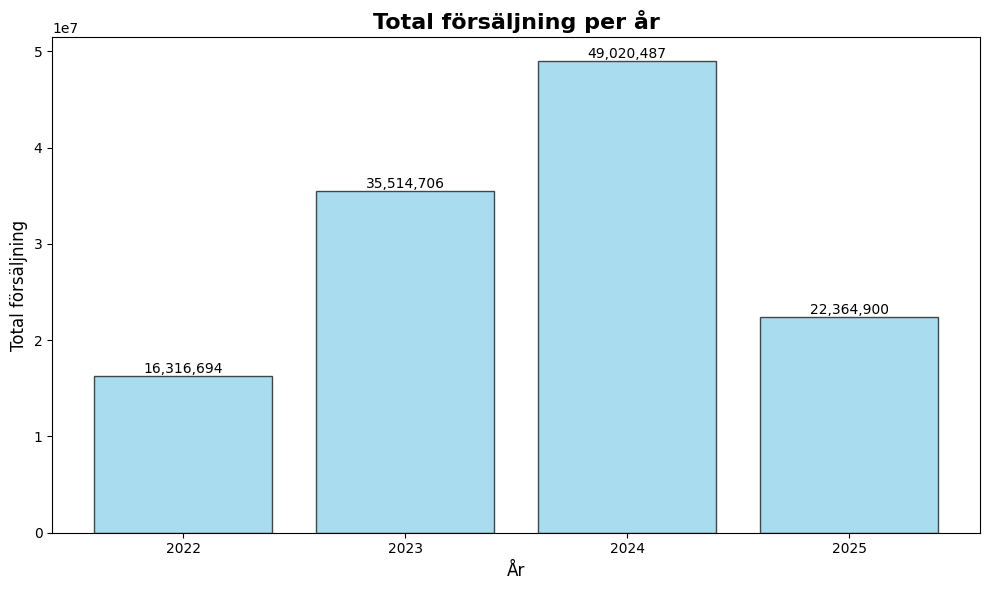

Störst försäljning år: 2024 (49020486.51)
Minst försäljning år: 2022 (16316694.17)


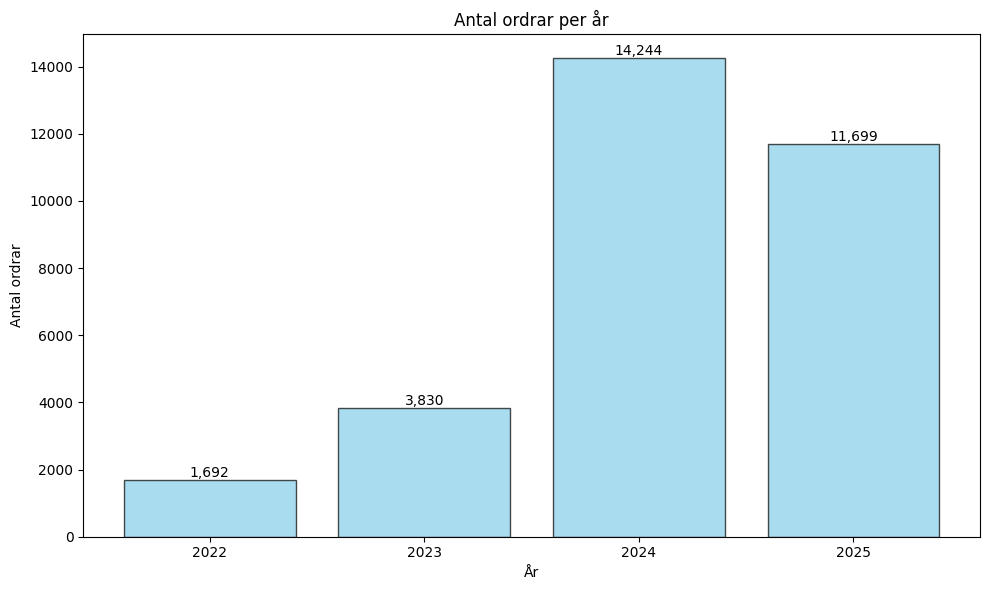

Mest ordrar år: 2024 (14244)
Minst ordrar år: 2022 (1692)


In [6]:
query = """
SELECT
    YEAR(OrderDate) AS OrderYear,
    SUM(TotalDue) AS TotalSales,
    COUNT(SalesOrderID) AS OrderCount
FROM Sales.SalesOrderHeader
GROUP BY YEAR(OrderDate)
ORDER BY OrderYear;
"""

df_year = pd.read_sql(query, engine)

df_year['TotalSales'] = df_year['TotalSales'].round(2)


df_year['OrderYear'] = df_year['OrderYear'].astype(int)

plt.figure(figsize=(10,6))
bars=plt.bar(df_year['OrderYear'], df_year['TotalSales'], color='skyblue', edgecolor='black', alpha= 0.7)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:,.0f}', 
             ha='center', va='bottom', fontsize=10)


plt.title("Total försäljning per år", fontsize=16, fontweight="bold")
plt.xlabel("År", fontsize=12)
plt.ylabel("Total försäljning", fontsize=12)
plt.xticks(df_year['OrderYear'])  # <-- FIX
plt.tight_layout()
plt.show()

max_row = df_year.loc[df_year['TotalSales'].idxmax()]
min_row = df_year.loc[df_year['TotalSales'].idxmin()]

print(f'Störst försäljning år: {int(max_row['OrderYear'])} ({max_row['TotalSales']:})')
print(f'Minst försäljning år: {int(min_row['OrderYear'])} ({min_row['TotalSales']:})')

plt.figure(figsize=(10,6))
bars=plt.bar(df_year['OrderYear'], df_year['OrderCount'], color='skyblue', edgecolor='black', alpha= 0.7)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:,.0f}', 
             ha='center', va='bottom', fontsize=10)
plt.title("Antal ordrar per år")
plt.xlabel("År")
plt.ylabel("Antal ordrar")
plt.xticks(df_year['OrderYear'])  # <-- FIX
plt.tight_layout()
plt.show()

max_row = df_year.loc[df_year['OrderCount'].idxmax()]
min_row = df_year.loc[df_year['OrderCount'].idxmin()]

print(f'Mest ordrar år: {int(max_row['OrderYear'])} ({int(max_row['OrderCount'])})')
print(f'Minst ordrar år: {int(min_row['OrderYear'])} ({int(min_row['OrderCount'])})')



**Insikter**

- Året med högst total försäljning är **2024**, med en försäljning på **49020486.51**.  
- Året med flest total försäljning är **2022**, med en försäljning på **16316694.17**.

- Året med högst ordrar är **2024**, med totalt **14244** ordrar.
- Året med flest ordrar är **2022**, med totalt **1692** ordrar.
- Analysen visar att **både försäljning och antal ordrar ökar** över tid och vi har inte hela årets data för 2025 och därför det ser mindre än 2024.
- I 2024 ökar antalet ordrar snabbare än försäljningen, vilket kan indikera ett mindre genomsnittligt ordervärde.


### 5: Top 10 produkter efter försäljning

**Affärsfråga:**  
Vilka 10 produkter genererar mest försäljning?

**Visualisering:**  
- Horisontellt stapeldiagram  
- Sorterat från högst till lägst försäljning  


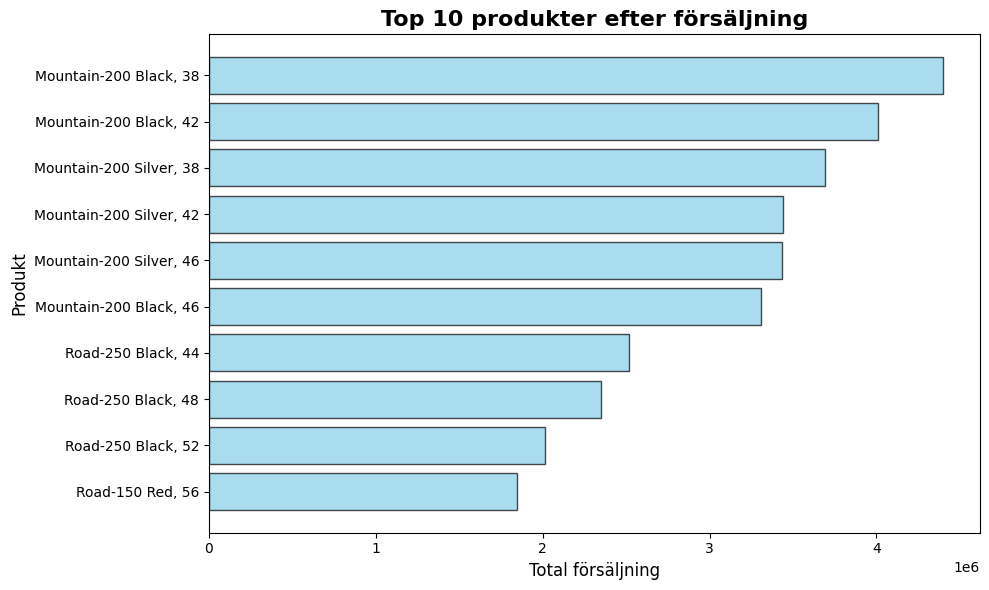

In [7]:
query = """
SELECT TOP 10
    p.Name AS ProductName,
    Round(SUM(sod.LineTotal), 2) AS TotalSales
FROM Sales.SalesOrderDetail sod
JOIN Production.Product p
    ON sod.ProductID = p.ProductID
GROUP BY p.Name
ORDER BY TotalSales DESC;
"""

df_top10 = pd.read_sql(query, engine)
df_top10 = df_top10.sort_values('TotalSales')
df_top10


plt.figure(figsize=(10,6))
plt.barh(df_top10['ProductName'], df_top10['TotalSales'], color='skyblue', edgecolor='black', alpha= 0.7)
plt.title("Top 10 produkter efter försäljning", fontsize=16, fontweight="bold")
plt.xlabel("Total försäljning", fontsize=12)
plt.ylabel("Produkt", fontsize=12)
plt.tight_layout()
plt.show()


**Insikter**

- Den produkt som genererar mest försäljning är **Mountain-200 Black, 38**  med en total försäljning på **4400592.8**.

- Analysen av topp 10 produkter visar att **Mountain-200** dominerar listan  med flest produkter bland de tio mest säljande.

- Detta indikerar att denna kategori är en viktig intäktsdrivare  för företaget.


### 6: Försäljning och antal kunder per region 

**Affärsfråga:**

- Hur skiljer sig försäljningen mellan olika regioner, och hur många unika kunder har varje region?

**Visualisering:** 
- En stapel för försäljning, en stapel för antal kunder
- Sortera regioner från högst försäljning



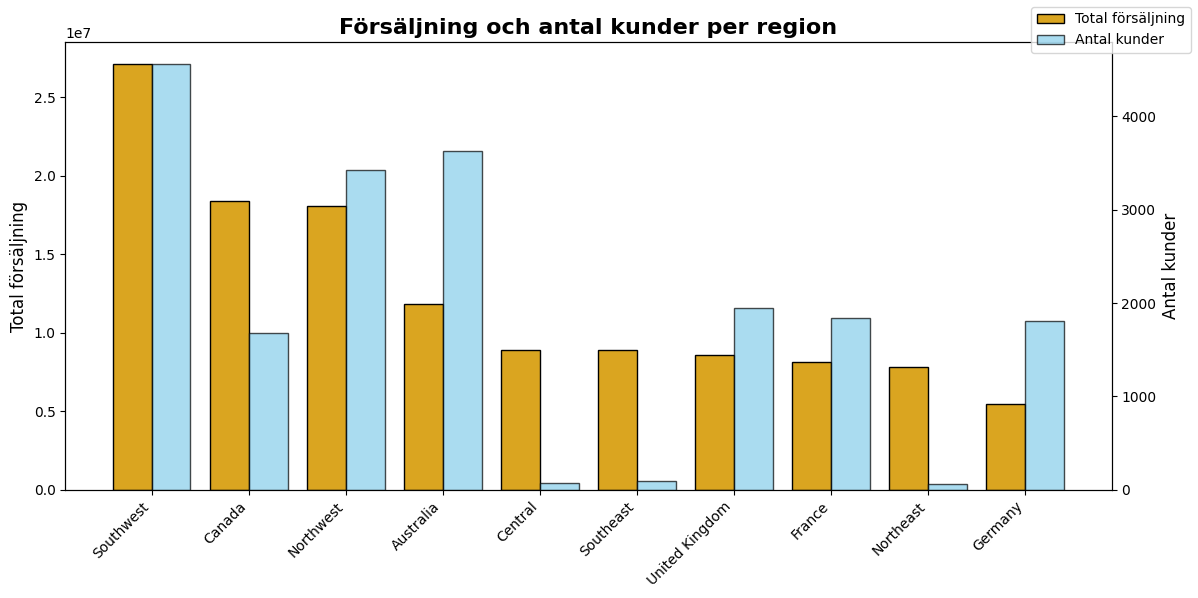

,Region,TotalSales,UniqueCustomers,SalesPerCustomer
0,Southwest,27150594.59,4565,5947.56
1,Canada,18398929.19,1677,10971.34
2,Northwest,18061660.37,3428,5268.86
3,Australia,11814376.10,3625,3259.14
4,Central,8913299.25,69,129178.25
5,Southeast,8884099.37,91,97627.47
6,United Kingdom,8574048.71,1951,4394.69
7,France,8119749.35,1844,4403.33
8,Northeast,7820209.63,57,137196.66
9,Germany,5479819.58,1812,3024.18


In [8]:
query = """
SELECT
    st.Name AS Region,
    ROUND(SUM(soh.TotalDue), 2) AS TotalSales,
    COUNT(DISTINCT c.CustomerID) AS UniqueCustomers
FROM Sales.SalesOrderHeader soh
JOIN Sales.SalesTerritory st
    ON soh.TerritoryID = st.TerritoryID
JOIN Sales.Customer c
    ON soh.CustomerID = c.CustomerID
GROUP BY st.Name
ORDER BY TotalSales DESC;
"""


df_region = pd.read_sql(query, engine)
df_region


x = np.arange(len(df_region))
width = 0.4

fig, ax1 = plt.subplots(figsize=(12,6))

# Stapel 1 – Försäljning
ax1.bar(x - width/2, df_region['TotalSales'], width, color='goldenrod', edgecolor='black', label='Total försäljning')
ax1.set_ylabel('Total försäljning', fontsize=12)

# Stapel 2 – Antal kunder (andra axeln)
ax2 = ax1.twinx()
ax2.bar(x + width/2, df_region['UniqueCustomers'], width, color='skyblue', edgecolor='black', alpha= 0.7, label='Antal kunder')
ax2.set_ylabel('Antal kunder', fontsize=12)

# X-axel
ax1.set_xticks(x)
ax1.set_xticklabels(df_region['Region'], rotation=45, ha='right')

# Titel
plt.title("Försäljning och antal kunder per region", fontsize=16, fontweight="bold")

# Legend (kombinerad)
fig.legend(loc="upper right")

plt.tight_layout()
plt.show()


top_sales_region = df_region.loc[df_region['TotalSales'].idxmax()]
top_sales_region

df_region['SalesPerCustomer'] = (
    df_region['TotalSales'] / df_region['UniqueCustomers']
).round(2)

df_region['SalesPerCustomer'] = df_region['SalesPerCustomer'].round(2)
df_region






**Insikter**

- Regionen med högst total försäljning är **Southwest** med **27150594.59** i försäljning.

- Den svagaste regionen är **Germany** med **5479819.58** i försäljning.

- Trots att Southwest har högst försäljning har den inte bra försäljning per kund, vilket tyder på att regionen har fler kunder med lägre ordervärden.

- Noreast har minst kund(57) med högst försäljning per kund **137196.66**


### 7: Genomsnittligt ordervärde per region och kundtyp

**Affärsfråga:**

- Vilka regioner har högst/lägst genomsnittligt ordervärde, och skiljer det sig mellan individuella kunder och företagskunder?

**visualisering:**

- Två staplar per region: en för Store, en för Individual(men det finns inte Store i databasen)

- Sortera regioner från högst genomsnitt (totalt)


['Individual']


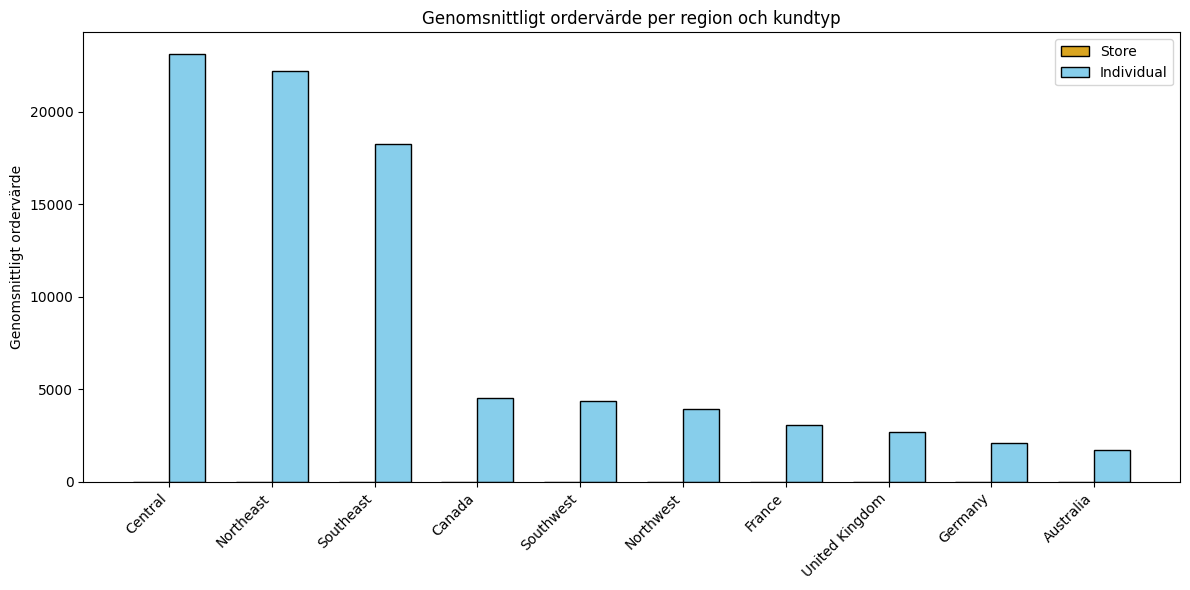

In [9]:
query = """
SELECT 
    st.Name AS Region,
    CASE 
        WHEN s.BusinessEntityID IS NOT NULL THEN 'Store'
        ELSE 'Individual'
    END AS CustomerType,
    ROUND(SUM(soh.TotalDue) * 1.0 / COUNT(soh.SalesOrderID), 2) AS AvgOrderValue
FROM Sales.SalesOrderHeader soh
JOIN Sales.SalesTerritory st
    ON soh.TerritoryID = st.TerritoryID
JOIN Sales.Customer c
    ON soh.CustomerID = c.CustomerID
LEFT JOIN Sales.Store s
    ON c.CustomerID = s.BusinessEntityID
GROUP BY st.Name,
         CASE 
             WHEN s.BusinessEntityID IS NOT NULL THEN 'Store'
             ELSE 'Individual'
         END
ORDER BY AvgOrderValue DESC;

"""

df_avg = pd.read_sql(query, engine)
df_avg
print(df_avg['CustomerType'].unique())

region_order = df_avg.groupby('Region')['AvgOrderValue'].sum().sort_values(ascending=False).index
df_avg['Region'] = pd.Categorical(df_avg['Region'], categories=region_order, ordered=True)
df_avg = df_avg.sort_values(['Region', 'CustomerType'])

# Pivotera data så vi får Store och Individual som kolumner

df_pivot = df_avg.pivot(index='Region', columns='CustomerType', values='AvgOrderValue').fillna(0)

# Säkerställ att båda kolumnerna finns
for col in ['Store', 'Individual']:
    if col not in df_pivot.columns:
        df_pivot[col] = 0

# Rita grupperat stapeldiagram

regions = df_pivot.index
x = np.arange(len(regions))
width = 0.35

fig, ax = plt.subplots(figsize=(12,6))

# Store staplar (burn yellow)
ax.bar(x - width/2, df_pivot['Store'], width, label='Store', color="goldenrod", edgecolor='black', linewidth=1)

# Individual staplar (skyblue)
ax.bar(x + width/2, df_pivot['Individual'], width, label='Individual', color='skyblue', edgecolor='black', linewidth=1)

ax.set_xticks(x)
ax.set_xticklabels(regions, rotation=45, ha='right')


ax.set_ylabel("Genomsnittligt ordervärde")
plt.title("Genomsnittligt ordervärde per region och kundtyp")
plt.legend()

plt.tight_layout()
plt.show()



**Insikt**
 
- Databasen har ingen Store-order därför kan inte jämföra Store vs Individual ordervärde? 

- Regionen med högst genomsnittligt ordervärde är **Central** med **23151.43**.
